In [2]:
import sys
import torch
import warnings
import torchvision
import numpy as np
import torch.nn as nn
import torch.utils.data
import torch.optim as optim
import torch.nn.functional as F
import torchvision.utils as vutils

from tqdm.auto import trange
from scipy.stats import entropy
from torchvision import transforms
from torch.autograd import Variable
from torch.nn import functional as F
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from torchvision.models.inception import inception_v3

warnings.filterwarnings('ignore')
np.set_printoptions(threshold=sys.maxsize)

In [193]:
batch_size = 128
image_size = 32
timesteps = 16
time_bar = 1 - np.linspace(0, 1.0, timesteps + 1)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [194]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

Files already downloaded and verified


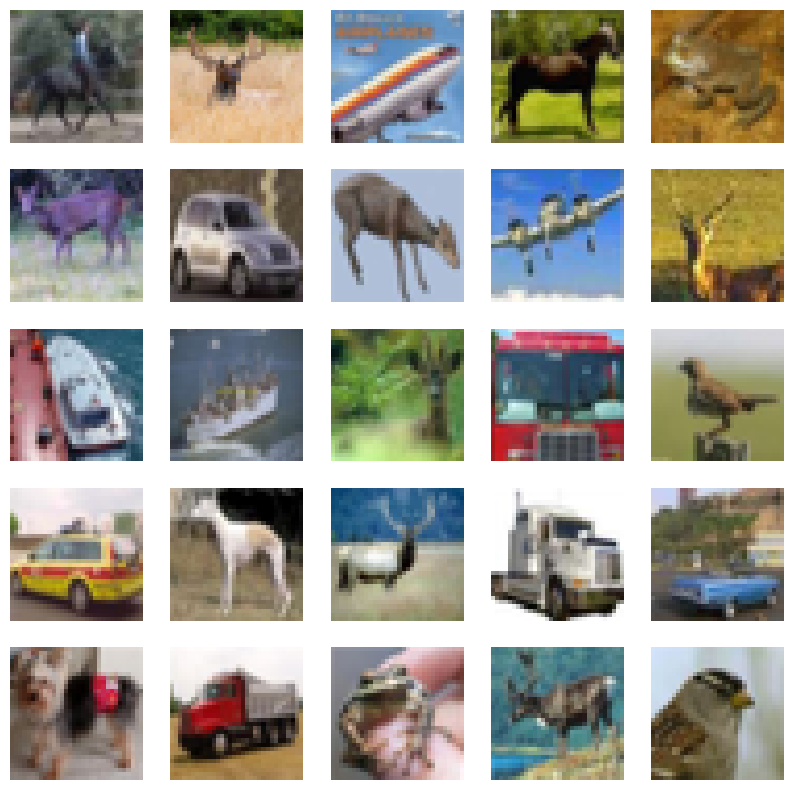

In [195]:
def cvtImg(img):
    img = img.permute([0, 2, 3, 1])
    img = img - img.min()
    img = (img / img.max())
    return img.numpy().astype(np.float32)

def show_examples(x):
    plt.figure(figsize=(10, 10))
    imgs = cvtImg(x)
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(imgs[i])
        plt.axis('off')

x, _ = next(iter(trainloader))
show_examples(x)

In [ ]:
def forward_noise(x, t):
    a = time_bar[t]
    b = time_bar[t + 1]

    noise = np.random.normal(size=x.shape)
    a = a.reshape((-1, 1, 1, 1))
    b = b.reshape((-1, 1, 1, 1))
    img_a = x * (1 - a) + noise * a
    img_b = x * (1 - b) + noise * b
    return img_a, img_b

def generate_ts(num):
    return np.random.randint(0, timesteps, size=num)

In [197]:
class Block(nn.Module):
    def __init__(self, in_channels=128, size=32):
        super(Block, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=128, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=in_channels, out_channels=128, kernel_size=3, padding=1)

        self.linear = nn.Linear(192, 128)
        self.norm = nn.LayerNorm([128, size, size])

    def forward(self, x_img, x_ts):
        x = F.relu(self.conv1(x_img))
        time = F.relu(self.linear(x_ts))
        time = time.view(-1, 128, 1, 1)
        x = x * time

        output = self.conv2(x_img)
        output = output + x
        output = F.relu(self.norm(output))
        return output
    
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(2240, 128),
            nn.LayerNorm([128]),
            nn.ReLU(),
            nn.Linear(128, 32*4*4),
            nn.LayerNorm([32*4*4]),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.mlp(x)

In [198]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()

        self.l_ts = nn.Sequential(
            nn.Linear(1, 192),
            nn.LayerNorm([192]),
            nn.ReLU(),
        )

        self.down_x32 = Block(in_channels=3, size=32)
        self.down_x16 = Block(size=16)
        self.down_x8 = Block(size=8)
        self.down_x4 = Block(size=4)

        self.mlp = MLP()

        self.up_x4 = Block(in_channels=32 + 128, size=4)
        self.up_x8 = Block(in_channels=256, size=8)
        self.up_x16 = Block(in_channels=256, size=16)
        self.up_x32 = Block(in_channels=256, size=32)

        self.cnn_output = nn.Conv2d(in_channels=128, out_channels=3, kernel_size=1, padding=0)
        self.opt = optim.Adam(self.parameters(), lr=0.0008)

    def forward(self, x, x_ts):
        x_ts = self.l_ts(x_ts)

        blocks = [self.down_x32, self.down_x16, self.down_x8, self.down_x4]
        x_left_layers = []
        for i, block in enumerate(blocks):
            x = block(x, x_ts)
            x_left_layers.append(x)
            x = F.max_pool2d(x, 2)

        x = x.view(-1, 128 * 4 * 4)
        x = torch.cat([x, x_ts], dim=1)
        x = self.mlp(x)
        x = x.view(-1, 32, 4, 4)

        blocks = [self.up_x4, self.up_x8, self.up_x16, self.up_x32]
        for i, block in enumerate(blocks):
            x_left = x_left_layers[len(blocks) - i - 1]
            x = torch.cat([x, x_left], dim=1)
            x = block(x, x_ts)
            x = F.interpolate(x, scale_factor=2, mode='bilinear')

        x = self.cnn_output(x)
        return x

In [203]:
def train(model, n_epochs):
    losses = []
    for i in range(n_epochs):
        t_loss = 0
        for img, _ in trainloader:
            x_ts = generate_ts(len(img))
            x_a, x_b = forward_noise(img, x_ts)

            x_ts = torch.from_numpy(x_ts).view(-1, 1).float().to(device)
            x_a = x_a.float().to(device)
            x_b = x_b.float().to(device)

            y_pred = model(x_a, x_ts)
            loss = torch.mean(torch.abs(y_pred - x_b))
            model.opt.zero_grad()
            loss.backward()
            model.opt.step()

            t_loss += loss.item()
        losses.append(t_loss / len(trainloader))
        print('Epoch: {}/{} Loss: {:.4f}'.format(1+i, n_epochs, losses[-1]))
    return losses

n_epochs = 30
model = Model().to(device)
losses = train(model, n_epochs)

Epoch: 1/30 Loss: 0.0675
Epoch: 2/30 Loss: 0.0328
Epoch: 3/30 Loss: 0.0300
Epoch: 4/30 Loss: 0.0286
Epoch: 5/30 Loss: 0.0276
Epoch: 6/30 Loss: 0.0268
Epoch: 7/30 Loss: 0.0260
Epoch: 8/30 Loss: 0.0253
Epoch: 9/30 Loss: 0.0245
Epoch: 10/30 Loss: 0.0243
Epoch: 11/30 Loss: 0.0237
Epoch: 12/30 Loss: 0.0233
Epoch: 13/30 Loss: 0.0234
Epoch: 14/30 Loss: 0.0231
Epoch: 15/30 Loss: 0.0227
Epoch: 16/30 Loss: 0.0225
Epoch: 17/30 Loss: 0.0225
Epoch: 18/30 Loss: 0.0224
Epoch: 19/30 Loss: 0.0223
Epoch: 20/30 Loss: 0.0223
Epoch: 21/30 Loss: 0.0220
Epoch: 22/30 Loss: 0.0220
Epoch: 23/30 Loss: 0.0221
Epoch: 24/30 Loss: 0.0218
Epoch: 25/30 Loss: 0.0219
Epoch: 26/30 Loss: 0.0217
Epoch: 27/30 Loss: 0.0218
Epoch: 28/30 Loss: 0.0217
Epoch: 29/30 Loss: 0.0216
Epoch: 30/30 Loss: 0.0215


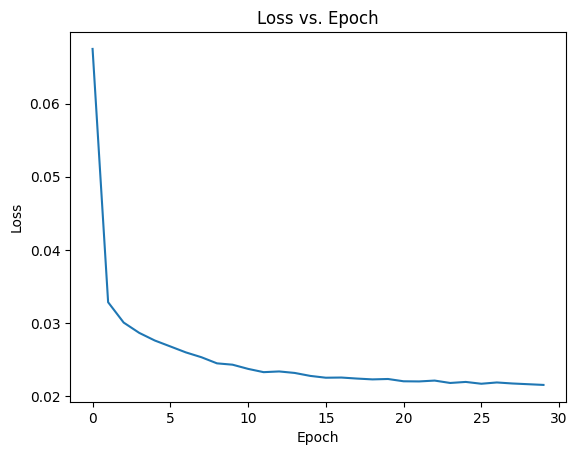

In [204]:
# Plot of Loss vs Epoch curve
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.show()

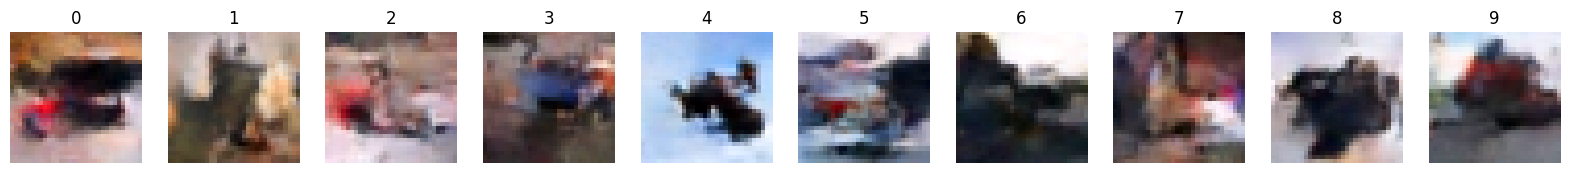

In [3]:
# Generate images from the learned distribution
def generate_images(num_images):
    model.eval()
    xs = []
    generated_images = []

    with torch.no_grad():
        for _ in trange(num_images):
            x = torch.randn(1, 3, image_size, image_size).to(device)
            for i in range(timesteps):
                t = i
                x = model(x, torch.full([1, 1], t, dtype=torch.float, device=device))
            xs.append(x[0].cpu())

    xs = torch.stack(xs, dim=0)
    xs = torch.clip(xs, -1, 1)
    xs = cvtImg(xs)

    plt.figure(figsize=(20, 2))
    for i in range(len(xs)):
        plt.subplot(1, len(xs), i+1)
        plt.imshow(xs[i])
        plt.title(f'{i}')
        generated_images.append(torch.tensor(xs[i]).unsqueeze(0).permute(0,3,2,1))
        vutils.save_image(torch.tensor(xs[i]).unsqueeze(0).permute(0,3,2,1), f"d_image_{i+1}.png", normalize=True)
        plt.axis('off')

    return generated_images

images = generate_images(10)

In [210]:
# Inception score of the generated images
def inception_score(imgs, cuda=True, batch_size=20, resize=False, splits=1):
    N = len(imgs)

    assert batch_size > 0
    assert N == batch_size

    # Set up dtype
    if cuda:
        dtype = torch.cuda.FloatTensor
    else:
        dtype = torch.FloatTensor

    imgs_tensor = torch.cat(imgs, dim=0).type(dtype)
    dataloader = torch.utils.data.DataLoader(imgs_tensor, batch_size=batch_size)
    inception_model = inception_v3(pretrained=True, transform_input=False).type(dtype)
    inception_model.eval()
    up = nn.Upsample(size=(299, 299), mode='bilinear').type(dtype)

    def get_pred(x):
        if resize:
            x = up(x)
        x = inception_model(x)
        return F.softmax(x, dim=1).data.cpu().numpy()

    preds = np.zeros((N, 1000))

    for i, batch in enumerate(dataloader, 0):
        batchv = Variable(batch)

        preds[i * batch_size:i * batch_size + batch_size] = get_pred(batchv)

    # compute the mean kl-div
    split_scores = []

    for k in range(splits):
        part = preds[k * (N // splits): (k + 1) * (N // splits), :]
        py = np.mean(part, axis=0)
        scores = []
        for i in range(part.shape[0]):
            pyx = part[i, :]
            scores.append(entropy(pyx, py))
        split_scores.append(np.exp(np.mean(scores)))

    return np.mean(split_scores), np.std(split_scores)

print("Calculating Inception Score...")
print(inception_score(images, cuda=True, batch_size=10, resize=True, splits=1))

Calculating Inception Score...
(2.2181541508292115, 0.0)
